# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.  
Для оценки качества модели мы будем использовать метрику MAPE (mean absolute percentage error) — средняя абсолютная процентная ошибка.

**Описание признаков:**
* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве;
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import category_encoders as ce

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import time 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import metrics
import catboost as cb

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\levte\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [3]:
# загружаем данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 
df_test['sample'] = 0
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)

/tmp/ipykernel_1660/2942978226.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

---
### Работа с пропусками и повторениями в данных
Найдем названия отелей, у которых не указаны координаты. Заранее отметим, что в тех записях, где есть пропуски в признаке lat, имеются пропуски и в признаке lng. Поэтому нам достаточно произвести поиск названий отелей, используя только один из признаков.

In [6]:
htls = data[data['lat'].isnull()]
lst = htls['hotel_name'].to_list()
unique_names = set(lst)
unique_names

{'Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'City Hotel Deutschmeister',
 'Cordial Theaterhotel Wien',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'Fleming s Selection Hotel Wien City',
 'Holiday Inn Paris Montmartre',
 'Hotel Advance',
 'Hotel Atlanta',
 'Hotel City Central',
 'Hotel Daniel Vienna',
 'Hotel Park Villa',
 'Hotel Pension Baron am Schottentor',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Mercure Paris Gare Montparnasse',
 'NH Collection Barcelona Podium',
 'Renaissance Barcelona Hotel',
 'Roomz Vienna'}

Так как отелей с пустыми значениями lat и lng не много, я заполнил их вручную. Координаты отелей были взяты из Google Maps.

In [7]:
locations = (
    ['Austria Trend Hotel Schloss Wilhelminenberg Wien', 48.22004119125541, 16.28436901270111], 
    ['City Hotel Deutschmeister', 48.22097339061746, 16.367062108664886],
    ['Cordial Theaterhotel Wien', 48.20969901650732, 16.35147402639736],
    ['Derag Livinghotel Kaiser Franz Joseph Vienna', 48.24604445462916, 16.34177869386189],
    ['Fleming s Selection Hotel Wien City', 48.20946611945889, 16.35400349702225],
    ['Holiday Inn Paris Montmartre', 48.889099640747816, 2.3337216258854276],
    ['Hotel Advance', 41.38340751885499, 2.1629710549770507],
    ['Hotel Atlanta', 48.220581929397355, 16.355764953383026],
    ['Hotel City Central', 48.2137441797507, 16.379833082843966],
    ['Hotel Daniel Vienna', 48.18895067196785, 16.383822212903848],
    ['Hotel Park Villa', 48.236161049232784, 16.345322775294097],
    ['Hotel Pension Baron am Schottentor', 48.2169997364819, 16.36053869887301],
    ['Maison Albar Hotel Paris Op ra Diamond', 48.87547956720175, 2.3239284393775503],
    ['Mercure Paris Gare Montparnasse', 48.84005922632249, 2.3235671605329835],
    ['NH Collection Barcelona Podium', 41.39172504609427, 2.1778832684700085],
    ['Renaissance Barcelona Hotel', 41.39279755334612, 2.1673868684700492],
    ['Roomz Vienna', 48.18790651932356, 16.420920188381313]
)

for x, y, z in locations:
    data[data['hotel_name'] == x] = data[data['hotel_name'] == x].fillna({'lat': y, 'lng': z})

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Отметим, что качество данных довольно хорошее, поэтому нам не пришлось тратить много времени на их очистку.

---
### Генерация новых признаков
1. Извлечем название города из признака hotel_address и занесем его в новый признак city.

In [9]:
addr = data['hotel_address']
addr = addr.apply(lambda x: x.split())
data['city'] = addr.apply(lambda x: x[-5] if x[-5] == 'London' else x[-2])

Посмотрим на соотношение количества отзывов об отелях в разрезе городов и на среднюю оценку отелей в каждом городе.

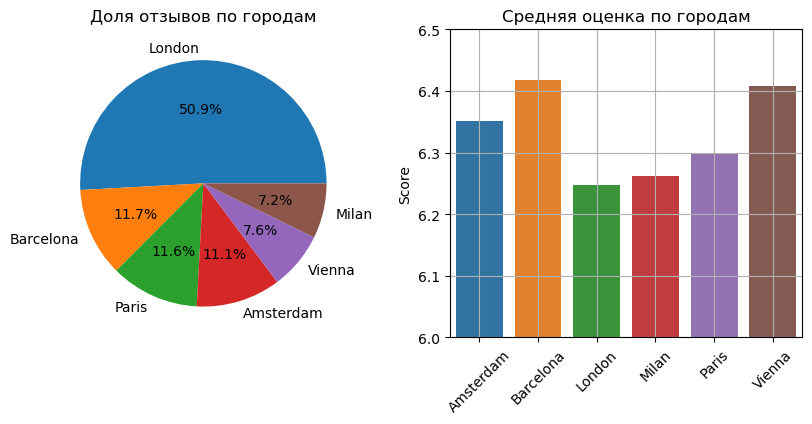

In [10]:
# создаем данные для визуализации 
city_count = data['city'].value_counts()

city_score = pd.pivot_table(
    data=data,
    index='city', 
    values='reviewer_score', 
    aggfunc=['mean'])

# визуализация
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].pie(
    city_count,
    labels = city_count.index,
    autopct = '%.1f%%'
)
axes[0].set_title('Доля отзывов по городам')

sns.barplot(
    data=city_score, 
    x=city_score.index, 
    y=city_score[('mean', 'reviewer_score')], 
    ax=axes[1]
)
axes[1].grid()
axes[1].xaxis.set_tick_params(rotation=45)
axes[1].set_xlabel('')
axes[1].set_ylabel('Score')
axes[1].set_ylim(6, 6.5)
axes[1].set_title('Средняя оценка по городам');

В датасете представлено всего 6 городов. 51% отзывов приходится на лондонские отели. При этом, средняя оценка во всех городах примерно одинаковая. Не наблюдается особой зависимости оценки от города, где расположен отель.

Создадим новый признак расстояния отелей от центров их городов.

In [11]:
# создаем инструменты для работы с геоданными
geolocator = Nominatim(user_agent="AV_Kaggle")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# создаем датасет из уникальных названий городов
cities = pd.DataFrame(data['city'].unique(), columns=['city_name'])
# находим координаты центров городов и добавляем их к датасету cities
cities['cntr_lat'], cities['cntr_lng'] = zip(*cities['city_name'].apply(lambda x: geolocator.geocode(x)[1]))
# создаем словарь с именами городов и координатами их центра
dict_cities = cities.set_index('city_name').to_dict('dict')
# создаем признаки с координатами центров городов в основном датасете
data['cntr_lat'] = data['city'].map(dict_cities['cntr_lat'])
data['cntr_lng'] = data['city'].map(dict_cities['cntr_lng'])
# находим расстояние от отеля до центра города в метрах и заносим в новый признак
data['cntr_dist'] = data.apply(lambda x: geodesic((x.lat,x.lng),(x.cntr_lat, x.cntr_lng)).meters, axis=1)

In [12]:
# удаляем лишние признаки, содержащие координаты центров городов
data.drop(['cntr_lat', 'cntr_lng'], axis=1, inplace=True)

Я решил также закодировать названия городов при помощи OneHotEncoder ради создания дополнительных признаков.

In [13]:
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True)
data = encoder.fit_transform(data)

2. Извлечем число, день недели, месяц и год из признака review_date и занесем их в 4 новых признака.

In [14]:
data['review_day'] = pd.to_datetime(data['review_date']).dt.day
data['review_dayofweek'] = pd.to_datetime(data['review_date']).dt.dayofweek
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_year'] = pd.to_datetime(data['review_date']).dt.year

Посмотрим на количество отзывов и среднюю оценку по месяцам.

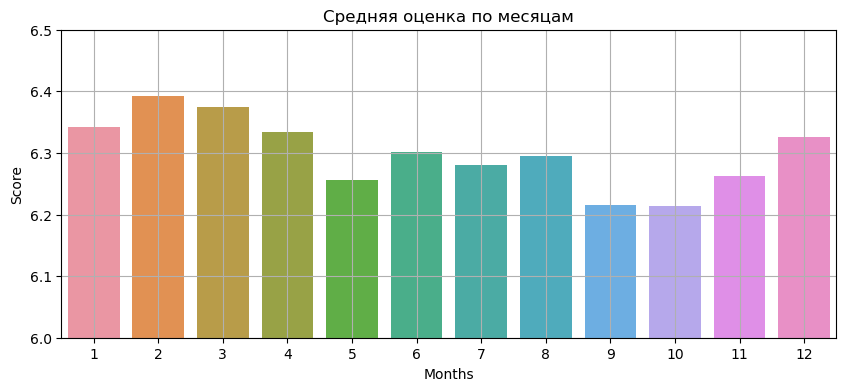

In [15]:
# создаем данные для визуализации
month_score = pd.pivot_table(
    data=data,
    index='review_month', 
    values='reviewer_score', 
    aggfunc=['mean'])

# визуализация
fig = plt.figure(figsize=(10, 4))
sns.barplot(
    data=month_score, 
    x=month_score.index, 
    y=month_score[('mean', 'reviewer_score')]
)
plt.grid()
plt.xlabel('Months')
plt.ylabel('Score')
plt.ylim(6, 6.5)
plt.title('Средняя оценка по месяцам');

Средняя оценка по месяцам варьируется в промежутке от 6.2 до 6.4. Не наблюдается особой зависимости оценки отеля от месяца/времени года.

3. Во время разбора признака reviewer_nationality, я заметил, что значения содержат пробелы в начале и конце строки. Для дальнейшего преобразования удалим эти пробелы.

In [16]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
data['reviewer_nationality'].value_counts()

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
                             ...  
Comoros                          1
Anguilla                         1
Tuvalu                           1
Cape Verde                       1
Palau                            1
Name: reviewer_nationality, Length: 227, dtype: int64

Почти половина из всех отзывов сделана гражданами Великобритании. Как видим, уникальных значений в признаке reviewer_nationality довольно много. Я решил не группировать их, а сразу закодировать при помощи BinaryEncoder.

In [17]:
encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
data = encoder.fit_transform(data)

4. Воспользуемся инструментом SentimentIntensityAnalyzer для определения тональности в признаках negative_review и positive_review. На основе тональности создадим 8 новых признаков.

In [18]:
# создаем инструмент для определния тональности
sia = SentimentIntensityAnalyzer()
# создаем признаки, которые принимают значения в виде словаря с оценками тональности
# на негатив, нейтральность, позитив и обобщенный коэфициент
data['sia_negative'] = data['negative_review'].apply(lambda x: sia.polarity_scores(x))
data['sia_positive'] = data['positive_review'].apply(lambda x: sia.polarity_scores(x))
# выделим оценку по каждой тональности в отдельный признак 
data['sia_negative_neg'] = data['sia_negative'].apply(lambda x: x['neg'])
data['sia_negative_neu'] = data['sia_negative'].apply(lambda x: x['neu'])
data['sia_negative_pos'] = data['sia_negative'].apply(lambda x: x['pos'])
data['sia_negative_comp'] = data['sia_negative'].apply(lambda x: x['compound'])
data['sia_positive_neg'] = data['sia_positive'].apply(lambda x: x['neg'])
data['sia_positive_neu'] = data['sia_positive'].apply(lambda x: x['neu'])
data['sia_positive_pos'] = data['sia_positive'].apply(lambda x: x['pos'])
data['sia_positive_comp'] = data['sia_positive'].apply(lambda x: x['compound'])

5. Избавимся от строковой части признака days_since_review и оставим только его числовую часть.

In [19]:
data['days_since_review'] = pd.to_numeric(data['days_since_review'].str.extract(r"\b(\d+)\b")[0], errors="coerce")

6. Преобразуем признак tags.

In [20]:
# создаем функцию для разделения тегов
def get_tags_num(x):
    x = x[2:-2]
    res = x.strip().split(' \', \' ')
    return res
# создаем признак с разделенными тегами
data['tags_split'] = data['tags'].apply(get_tags_num)

In [21]:
# cоздаем новые признаки из 20 самых популярных тегов
data_copy = data.explode('tags_split')
tags_count = data_copy['tags_split'].value_counts()[:20]
tags_data = pd.DataFrame(tags_count).reset_index()
tags_data.columns = ['unique', 'count']
tags_set = set(tags_data['unique'])

for i in tags_set:
    tag_name = str(i)
    data[tag_name] = data['tags_split'].apply(lambda x: 1 if tag_name in x else 0)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality_0                      515738 non-null  int64  
 6   reviewer_nationality_1                      515738 non-null  int64  
 7   reviewer_nationality_2                      515738 non-null  int64  
 8   reviewer_nationality_3                      515738 non-null  int64  
 9   reviewer_nationality_4                      515738 non-null  int64  
 

---
### Отбор признаков

In [23]:
# удалим признаки типа object
objects = [x for x in data.columns if data[x].dtypes == 'object']
data.drop(objects, axis=1, inplace=True)

Перед обучением мы можем оценить значимость каждого признака для целевой переменной — рейтинг отеля. Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

Но для начала сделаем копию нашего датасета и разделим его на X и y.

In [24]:
data_copy = data.drop(['sample'], axis=1).copy()
y_copy = data_copy['reviewer_score'].values
X_copy = data_copy.drop(['reviewer_score'], axis=1)

In [25]:
# непрерывные признаки
num_cols = [
    'additional_number_of_scoring', 
    'total_number_of_reviews', 
    'review_total_negative_word_counts', 
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'average_score',
    'lat',
    'lng',
    'cntr_dist',
    'sia_negative_neg',
    'sia_negative_neu',
    'sia_negative_pos',
    'sia_negative_comp',
    'sia_positive_neg',
    'sia_positive_neu',
    'sia_positive_pos',
    'sia_positive_comp'    
]
# категориальные признаки
cat_cols = [
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6',
    'reviewer_nationality_7',
    'city_Milan',
    'city_Paris',
    'city_Barcelona',
    'city_London',
    'city_Amsterdam',
    'city_Vienna',
    'review_day',
    'review_dayofweek',
    'review_month',
    'review_year',
    'Standard Double or Twin Room',
    'Stayed 4 nights',
    'Double Room',
    'Family with young children',
    'Stayed 3 nights',
    'Leisure trip',
    'Stayed 2 nights',
    'Superior Double Room',
    'Double or Twin Room',
    'Solo traveler',
    'Stayed 5 nights',
    'Standard Double Room',
    'Submitted from a mobile device',
    'Stayed 1 night',
    'Deluxe Double Room',
    'Group',
    'Classic Double Room',
    'Family with older children',
    'Business trip'
]
# сохраняем целевой признак в целочисленном формате
y_copy = y_copy.astype('int')

<Axes: >

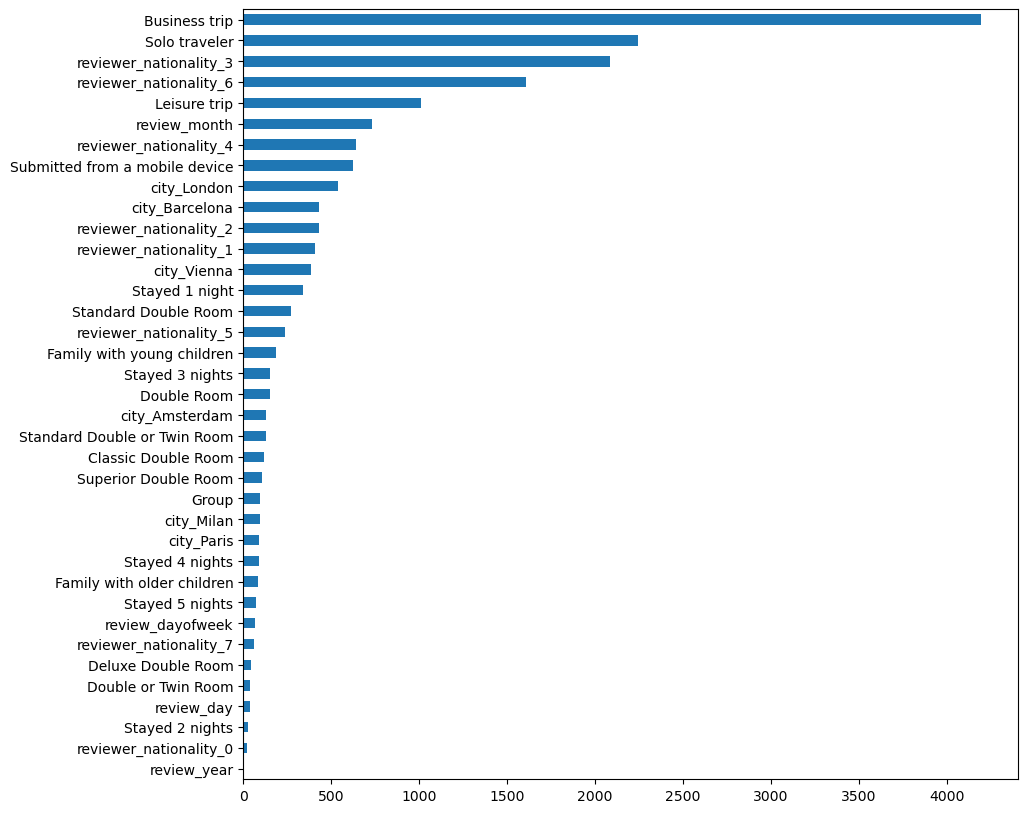

In [26]:
# оцениваем значимость категориальных переменных
fig = plt.figure(figsize=(10, 10))
imp_cat = pd.Series(chi2(X_copy[cat_cols], y_copy)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самым значимым категориальным признаком с большим отрывом является Business trip. Признак review_year оказался совсем бесполезным. Следует отметить, что новые признаки, полученные из tags и reviewer_nationality, оказались полезными для нашей модели. Хотя сначала я думал, что они не помогут нашей модели. Бинарные признаки городов оказались менее полезными.

<Axes: >

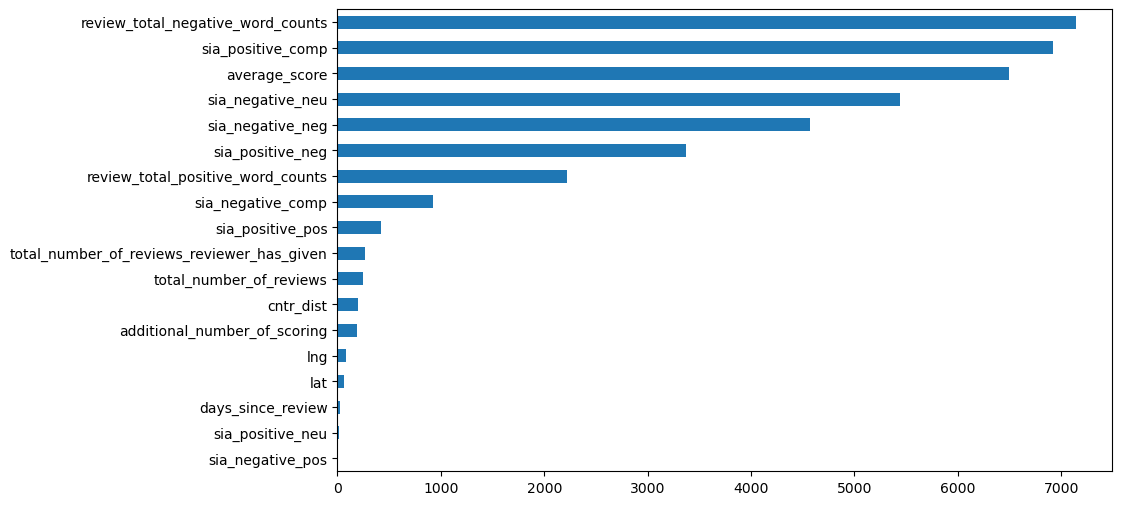

In [27]:
# оцениваем значимость непрерывных переменных
fig = plt.figure(figsize=(10, 6))
imp_num = pd.Series(f_classif(X_copy[num_cols], y_copy)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самыми важными для оценки признаками являются признаки, связанные непосредственно с отзывами. В частности, новые признаки, полученные из positive_review и negative_review, оказались очень полезны нашей модели. При этом, признаки sia_positive_neu и sia_negative_pos не имеют никакой важности для целевого признака.

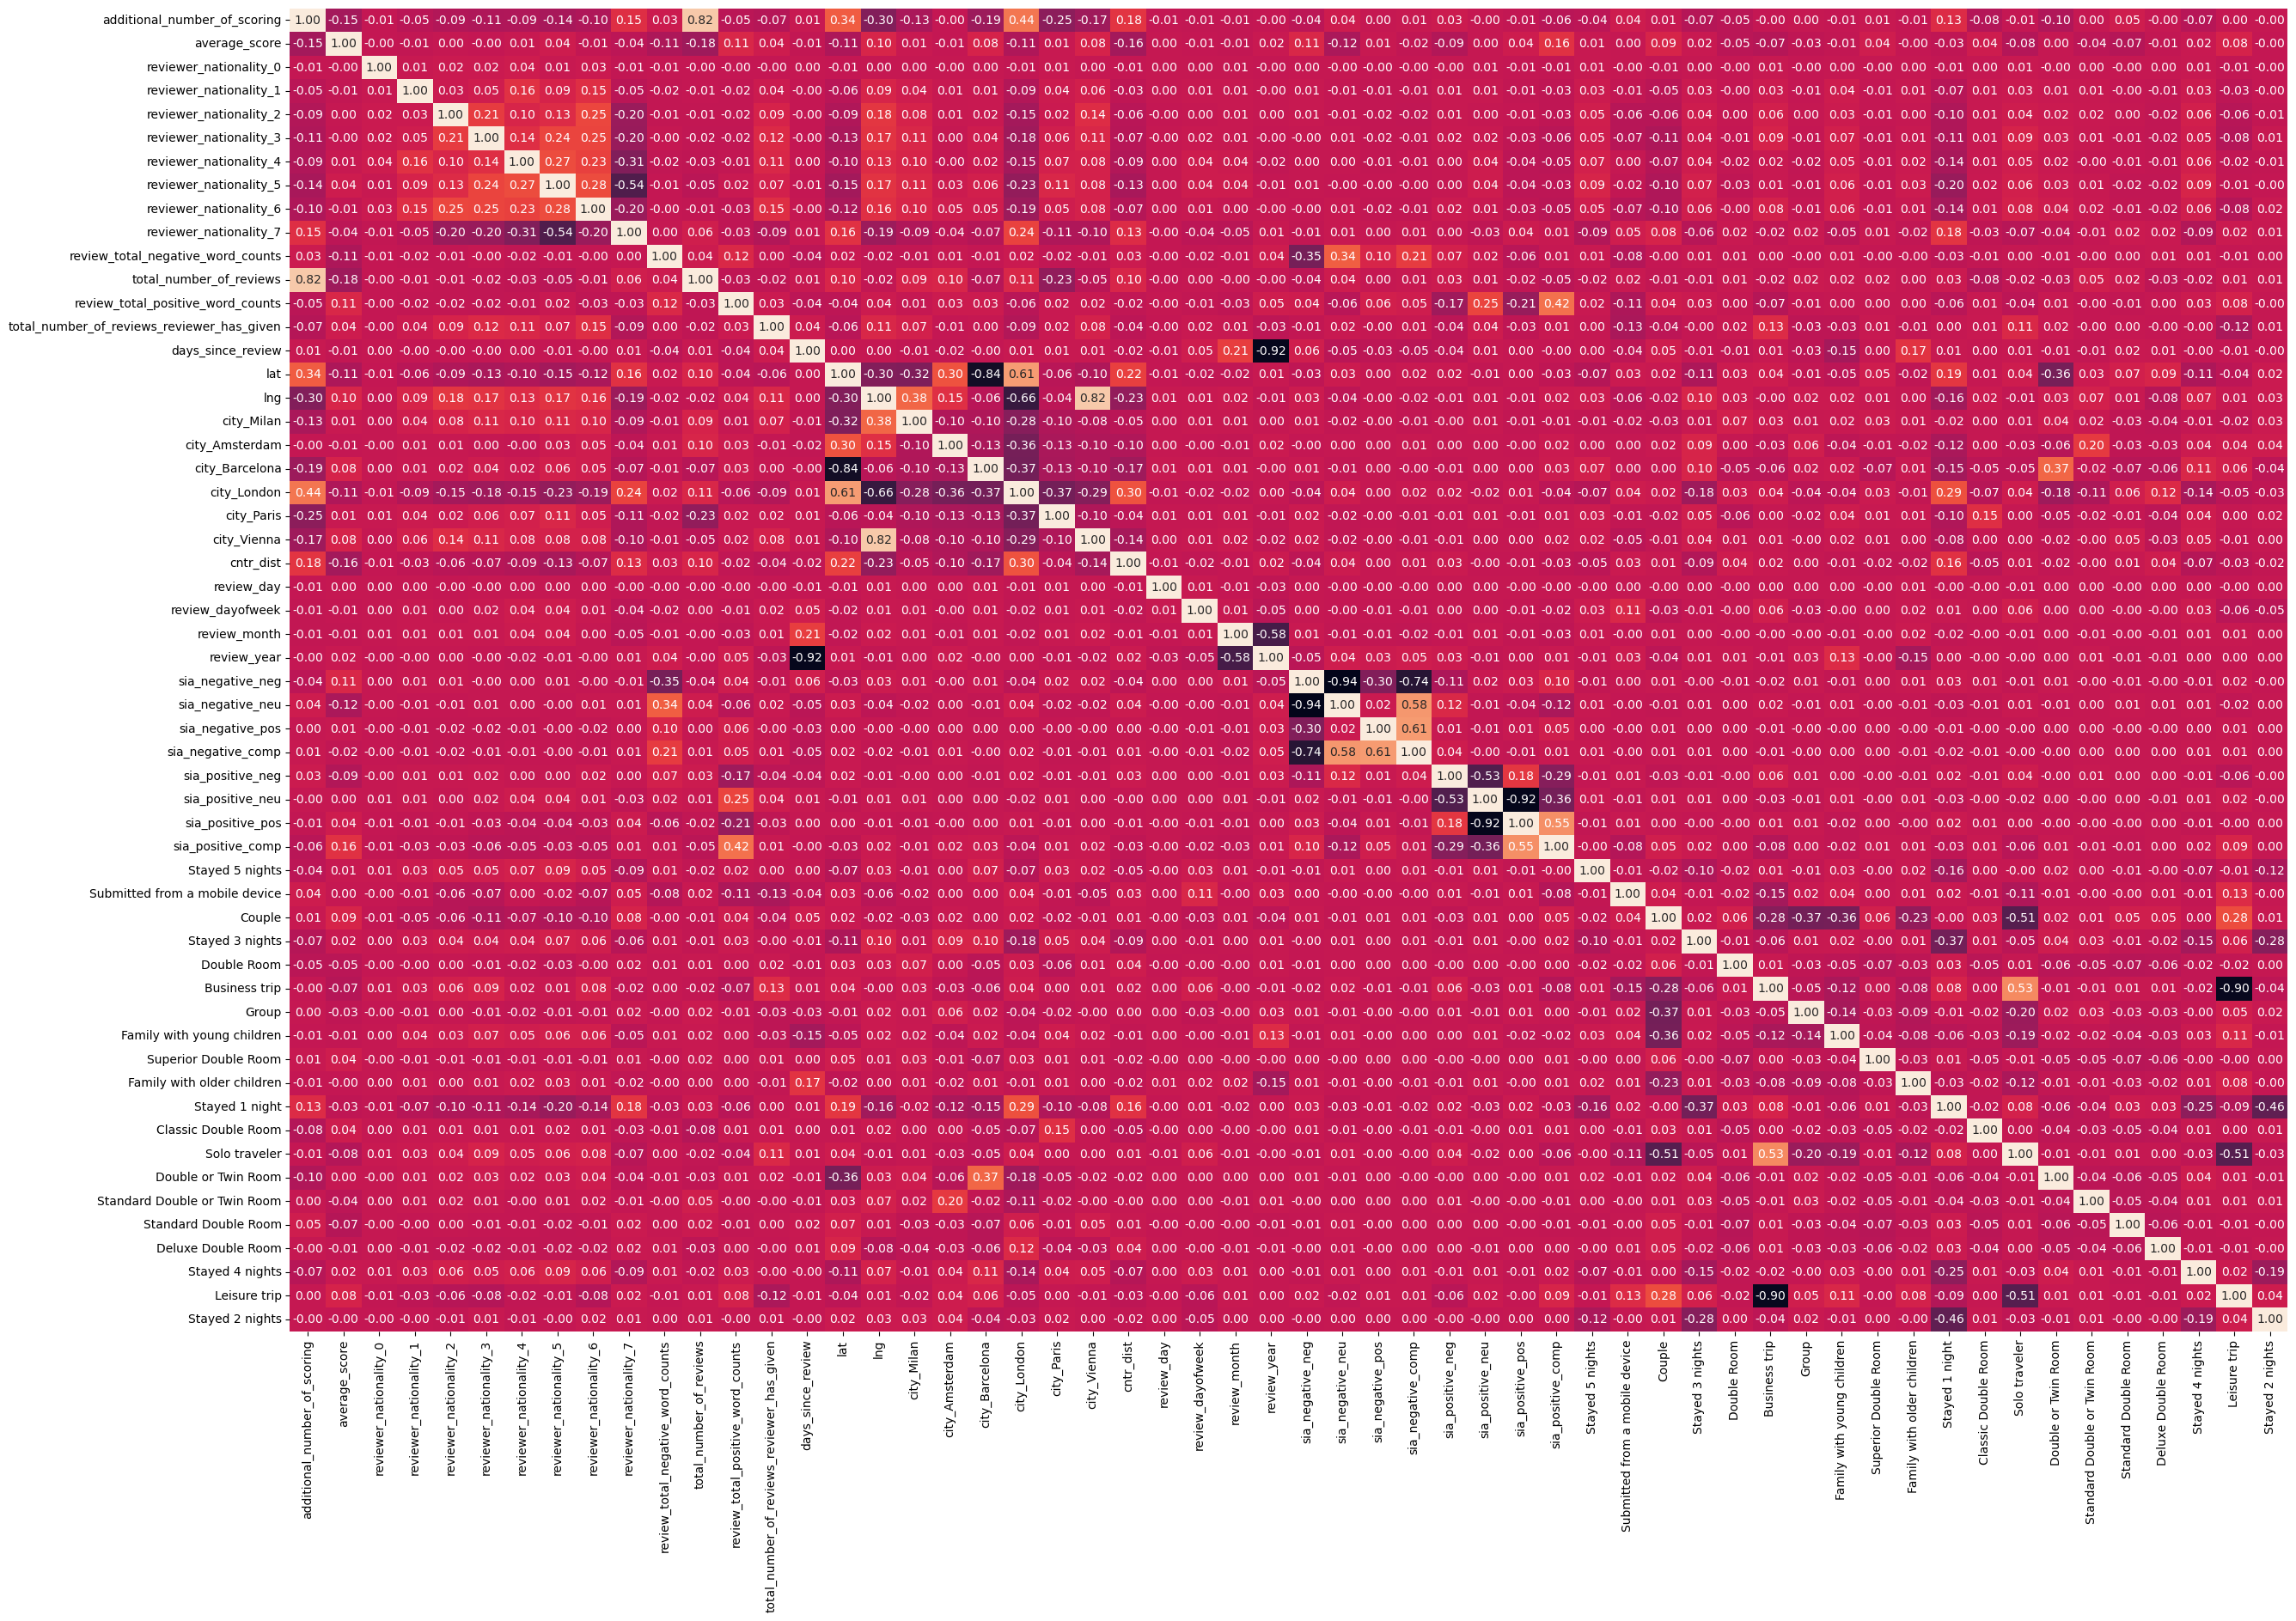

In [28]:
# построим тепловую карту корреляции признаков
fig = plt.figure(figsize=(30, 20))
sns.heatmap(
    X_copy.corr(), 
    annot=True, 
    fmt='.2f',
    cbar=False
);

Имеются мультиколлинеарные признаки. Обращаем внимание только на те пары признаков, у которых корреляция выше 90. Это - review_year и days_since_review, sia_neagtive_neg и sia_negative_neu, sia_positive_pos и sia_positive_neu. Принимая во внимание диаграммы значимости и корреляции, я решил избавиться от одного признака из каждой пары и признака sia_negative_pos.

In [29]:
drop_list = ['sia_negative_pos', 'sia_positive_neu', 'review_year', 'sia_negative_neg']
data.drop(drop_list, axis=1, inplace=True)

---
### Построение модели и вычисление метрики

In [30]:
# отделим обучающий датасет от контрольного
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
# отделим целевой признак в обучающем датасете
y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [31]:
# разделим обучающую выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 53), (386803, 53), (386803, 52), (290102, 52), (96701, 52))

Будем высчитывать метрику MAPE на основе трех моделей: RandomForestRegressor, HistGradientBoostingRegressor и CatBoostRegressor.

#### RandomForestRegressor

In [32]:
# создаем модель
model_rf = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
# обучаем модель на тренировочной выборке
model_rf.fit(X_train, y_train)
# делаем предсказание для тестовой выборки
y_pred = model_rf.predict(X_test)
# вычисляем метрику
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2)}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


MAPE: 12.53%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


#### HistGradientBoostingRegressor

In [33]:
# создаем модель
model_hgb = HistGradientBoostingRegressor(
    max_iter=100, 
    verbose=1
)
# обучаем модель на тренировочной выборке
model_hgb.fit(X_train, y_train)
# делаем предсказание для тестовой выборки
y_pred = model_hgb.predict(X_test)
# вычисляем метрику
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2)}%")

Binning 0.109 GB of training data: 0.980 s
Binning 0.012 GB of validation data: 0.021 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 6, train loss: 1.23083, val loss: 1.23026, in 0.062s
[2/100] 1 tree, 31 leaves, max depth = 6, train loss: 1.14234, val loss: 1.14113, in 0.059s
[3/100] 1 tree, 31 leaves, max depth = 7, train loss: 1.06923, val loss: 1.06833, in 0.055s
[4/100] 1 tree, 31 leaves, max depth = 6, train loss: 1.00905, val loss: 1.00809, in 0.056s
[5/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.95858, val loss: 0.95801, in 0.055s
[6/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.91694, val loss: 0.91646, in 0.055s
[7/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.88158, val loss: 0.88127, in 0.054s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.85149, val loss: 0.85137, in 0.055s
[9/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.82594, val loss: 0.82577, in 0.055s
[10/100] 1 tree, 31 leaves, max depth = 7, train lo

#### CatBoostRegressor

In [34]:
# создаем модель
model_cb = cb.CatBoostRegressor(
    n_estimators=100, 
    verbose=1, 
    random_state=42
)
# обучаем модель на тренировочной выборке
model_cb.fit(X_train, y_train)
# делаем предсказание для тестовой выборки
y_pred = model_cb.predict(X_test)
# вычисляем метрику
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2)}%")

Learning rate set to 0.5
0:	learn: 1.3681298	total: 100ms	remaining: 9.94s
1:	learn: 1.2628446	total: 140ms	remaining: 6.87s
2:	learn: 1.2192265	total: 180ms	remaining: 5.83s
3:	learn: 1.1970391	total: 220ms	remaining: 5.28s
4:	learn: 1.1841207	total: 255ms	remaining: 4.84s
5:	learn: 1.1770547	total: 287ms	remaining: 4.5s
6:	learn: 1.1720308	total: 325ms	remaining: 4.32s
7:	learn: 1.1689524	total: 362ms	remaining: 4.16s
8:	learn: 1.1671624	total: 393ms	remaining: 3.98s
9:	learn: 1.1656384	total: 424ms	remaining: 3.81s
10:	learn: 1.1641546	total: 458ms	remaining: 3.71s
11:	learn: 1.1619639	total: 497ms	remaining: 3.64s
12:	learn: 1.1613084	total: 532ms	remaining: 3.56s
13:	learn: 1.1593751	total: 570ms	remaining: 3.5s
14:	learn: 1.1584401	total: 608ms	remaining: 3.44s
15:	learn: 1.1576524	total: 646ms	remaining: 3.39s
16:	learn: 1.1558448	total: 688ms	remaining: 3.36s
17:	learn: 1.1550220	total: 726ms	remaining: 3.31s
18:	learn: 1.1538044	total: 770ms	remaining: 3.28s
19:	learn: 1.15253

Рассчеты HistGradientBoostingRegressor и CatBoostRegressor производились гораздо быстрее по сравнению с RandomForestRegressor. Результат метода CatBoostRegressor лучше остальных двух. Поэтому будем выполнять конечное предсказание на основе CatBoostRegressor.

---
### Делаем сабмишн

In [35]:
# удаляем целевой признак из тестовых данных
test_data = test_data.drop(['reviewer_score'], axis=1)

In [36]:
# делаем предсказание
predict_submission = model_cb.predict(test_data)
# заносим полученные предсказания оценок в сабмишн-датасет
sample_submission['reviewer_score'] = predict_submission
# выведем статистические показатели полученного датасета
sample_submission.describe()

,reviewer_score,id
count,128935.000000,128935.000000
mean,8.393659,258065.135533
std,1.178848,148917.547662
min,0.208370,2.000000
25%,7.741095,129124.000000
50%,8.694824,257459.000000
75%,9.319522,387599.000000
max,10.569792,515737.000000


In [37]:
# заменяем выбросы на адекватные оценки 
sample_submission['reviewer_score'] = sample_submission['reviewer_score'].apply(lambda x : 10 if x > 10 else x)
sample_submission['reviewer_score'] = sample_submission['reviewer_score'].apply(lambda x : 1.0 if x < 1.0 else x)

In [38]:
# сохраняем финальный датасет в csv-формате для сабмишна
sample_submission.to_csv('submission.csv', index=False)

---
### Заключение
В целом результат метрики удовлетворительный. Но думаю, что его можно улучшить, если постараться вытащить из positive_review и negative_review еще какие-нибудь дополнительные признаки.